In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
import gc
import shap
import glob
import seaborn as sns
import pyarrow.parquet as pq
from datetime import timedelta
from collections import Counter
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score ,log_loss, f1_score, recall_score

In [3]:
# TODO 

## more features

## target

In [4]:
def stats(data:pd.DataFrame) -> pd.DataFrame:
    maxx = []
    minn = []
    for i in data.columns:
        maxx.append(data[i].value_counts().max())
        minn.append(data[i].value_counts().min())

    return pd.DataFrame(
        {'nunique': data.nunique(),
         'len': len(data),
         'types':data.dtypes,
         'Nulls' : data.isna().sum(),
         "Value counts Max": maxx,
         'Value counts Min':minn 
        },
        columns = ['nunique', 'len','types','Nulls'
                   ,"Value counts Max",'Value counts Min']).\
        sort_values(by ='nunique',ascending = False)


def plot_shap_for_observation(N:int, shap_values: shap.Explanation) -> None:
    val = shap_values[N].values.sum() + shap_values[N].base_values.sum()
    prob = np.exp(val)/(1+np.exp(val))
    
    shap.plots.waterfall(shap_values[N],show = False)
    plt.title(f'N = {N} \n probability : {prob}')
    plt.show()

# load data and EDA

## load train data

In [5]:
train_files = glob.glob('/kaggle/input/neo-bank-non-sub-churn-prediction/train_*.parquet')

# Read all the files and concatenate them
df_train = pd.concat([pq.read_table(file).to_pandas() for file in train_files])
df_train = df_train.sort_values(by=['customer_id','date'])
df_train.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-17,0,0,...,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': ...",0,False,Amenity horticulturist,False,False
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-18,0,0,...,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': ...",1,False,Amenity horticulturist,False,False
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-19,0,0,...,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': ...",2,False,Amenity horticulturist,False,False
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-20,0,0,...,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': ...",3,False,Amenity horticulturist,False,False
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-21,0,0,...,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': ...",4,False,Amenity horticulturist,False,False


In [6]:
stats(df_train.select_dtypes(exclude = ['object']))

,nunique,len,types,Nulls,Value counts Max,Value counts Min
Id,3926058,3926058,int64,0,1,1
crypto_out_volume,3648444,3926058,float64,0,84415,1
bank_transfer_in_volume,3648444,3926058,float64,0,84415,1
crypto_in_volume,3648444,3926058,float64,0,84415,1
bank_transfer_out_volume,3648444,3926058,float64,0,84415,1
customer_id,106179,3926058,int64,0,362,1
bank_transfer_in,24245,3926058,int64,0,1199629,1
bank_transfer_out,15703,3926058,int64,0,2041907,1
date,5828,3926058,datetime64[ns],0,1593,5
tenure,5303,3926058,int64,0,96601,1


In [7]:
df_train.select_dtypes('object').head()

,name,country,date_of_birth,address,touchpoints,csat_scores,job
0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
1,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
2,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
3,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
4,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...","[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist


In [8]:
# no job/country/address change in train
for i in ['country','address','job']:
    print(df_train.groupby('customer_id')[i].nunique().value_counts())

country
1    106179
Name: count, dtype: int64
address
1    106179
Name: count, dtype: int64
job
1    106179
Name: count, dtype: int64


## load test data

In [9]:
df_test = pq.read_table('/kaggle/input/neo-bank-non-sub-churn-prediction/test.parquet').to_pandas() 
df_test = df_test.sort_values(by=['customer_id','date'])
df_test.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud
1097087,7284407,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2026-02-27,0,0,...,213.615319,0,[],"{'appointment': None, 'email': None, 'phone': ...",5398,False,Amenity horticulturist,False,Public,False
1040227,7227547,2,2.8,Bonnie Carr,Greece,1947-05-27,00867 Dominguez Camp Apt. 575\nPort Josephland...,2026-01-03,0,0,...,34.881290,0,[],"{'appointment': None, 'email': None, 'phone': ...",887,False,Exhibition designer,False,Public,False
392455,6579775,3,0.0,Michael Mcknight,Romania,2002-11-09,"36495 Travis Ranch Apt. 055\nJustinmouth, CO 7...",2024-10-27,0,0,...,1163.469651,0,[],"{'appointment': None, 'email': None, 'phone': ...",5217,False,"Engineer, broadcasting (operations)",False,Public,False
555437,6742757,4,3.2,Sharon Howard,Switzerland,1973-09-16,"4660 Wilson Streets Apt. 764\nSouth Amyside, P...",2025-02-22,0,0,...,119.017834,0,[],"{'appointment': None, 'email': None, 'phone': ...",448,False,Hydrographic surveyor,False,Public,False
38410,6225730,5,3.0,Emily Solis,Netherlands,2006-06-30,"664 Brown Rapid\nBrianburgh, MN 10337 Netherlands",2024-02-01,0,0,...,63.071141,0,"[phone, phone]","{'appointment': None, 'email': None, 'phone': ...",5859,False,Occupational hygienist,False,Private,False


In [10]:
# no job/country/address change  in test
for i in ['country','address','job','Usage']:
    print(df_test.groupby('customer_id')[i].nunique().value_counts())

country
1    165155
Name: count, dtype: int64
address
1    165155
Name: count, dtype: int64
job
1    165155
Name: count, dtype: int64
Usage
1    165090
2        65
Name: count, dtype: int64


In [11]:
df_test.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud
1097087,7284407,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2026-02-27,0,0,...,213.615319,0,[],"{'appointment': None, 'email': None, 'phone': ...",5398,False,Amenity horticulturist,False,Public,False
1040227,7227547,2,2.8,Bonnie Carr,Greece,1947-05-27,00867 Dominguez Camp Apt. 575\nPort Josephland...,2026-01-03,0,0,...,34.881290,0,[],"{'appointment': None, 'email': None, 'phone': ...",887,False,Exhibition designer,False,Public,False
392455,6579775,3,0.0,Michael Mcknight,Romania,2002-11-09,"36495 Travis Ranch Apt. 055\nJustinmouth, CO 7...",2024-10-27,0,0,...,1163.469651,0,[],"{'appointment': None, 'email': None, 'phone': ...",5217,False,"Engineer, broadcasting (operations)",False,Public,False
555437,6742757,4,3.2,Sharon Howard,Switzerland,1973-09-16,"4660 Wilson Streets Apt. 764\nSouth Amyside, P...",2025-02-22,0,0,...,119.017834,0,[],"{'appointment': None, 'email': None, 'phone': ...",448,False,Hydrographic surveyor,False,Public,False
38410,6225730,5,3.0,Emily Solis,Netherlands,2006-06-30,"664 Brown Rapid\nBrianburgh, MN 10337 Netherlands",2024-02-01,0,0,...,63.071141,0,"[phone, phone]","{'appointment': None, 'email': None, 'phone': ...",5859,False,Occupational hygienist,False,Private,False


In [12]:
stats(df_test.select_dtypes(exclude = ['object']))

,nunique,len,types,Nulls,Value counts Max,Value counts Min
Id,1360472,1360472,int64,0,1,1
crypto_out_volume,1358289,1360472,float64,0,2,1
bank_transfer_in_volume,1358289,1360472,float64,0,2,1
crypto_in_volume,1358289,1360472,float64,0,2,1
bank_transfer_out_volume,1358289,1360472,float64,0,2,1
customer_id,165155,1360472,int64,0,84,1
bank_transfer_in,22010,1360472,int64,0,521251,1
bank_transfer_out,16734,1360472,int64,0,699179,1
tenure,4831,1360472,int64,0,54198,1
date,1096,1360472,datetime64[ns],0,1643,17


In [13]:
df_test.select_dtypes('object').head()

,name,country,date_of_birth,address,touchpoints,csat_scores,job,Usage
1097087,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist,Public
1040227,Bonnie Carr,Greece,1947-05-27,00867 Dominguez Camp Apt. 575\nPort Josephland...,[],"{'appointment': None, 'email': None, 'phone': ...",Exhibition designer,Public
392455,Michael Mcknight,Romania,2002-11-09,"36495 Travis Ranch Apt. 055\nJustinmouth, CO 7...",[],"{'appointment': None, 'email': None, 'phone': ...","Engineer, broadcasting (operations)",Public
555437,Sharon Howard,Switzerland,1973-09-16,"4660 Wilson Streets Apt. 764\nSouth Amyside, P...",[],"{'appointment': None, 'email': None, 'phone': ...",Hydrographic surveyor,Public
38410,Emily Solis,Netherlands,2006-06-30,"664 Brown Rapid\nBrianburgh, MN 10337 Netherlands","[phone, phone]","{'appointment': None, 'email': None, 'phone': ...",Occupational hygienist,Private


## check time spans train

In [14]:
df_train['year'] = df_train.date.dt.year
df_train['month'] = df_train.date.dt.month

periods = df_train.groupby('customer_id').agg({'year':['min','max']}).droplevel(0, axis=1) 
periods['diff'] = periods['max']-periods['min']
periods.head()

,min,max,diff
customer_id,,,
1,2008,2022,14
2,2008,2010,2
3,2008,2022,14
4,2008,2009,1
5,2008,2023,15


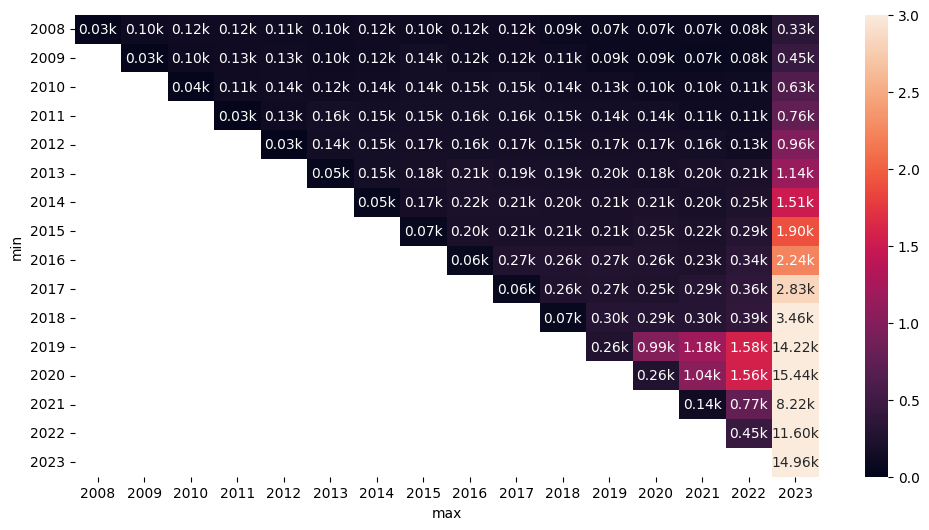

In [15]:

trans_matrix = periods.groupby(['min', 'max']).count().unstack()
trans_matrix.columns = trans_matrix.columns.droplevel()

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(trans_matrix/1000,vmin=0,vmax=3,annot=True,fmt='.2f')
for t in ax.texts: t.set_text(t.get_text() + "k")
plt.show()

### check time spans test

In [16]:
df_test['year'] = df_test.date.dt.year
df_test['month'] = df_test.date.dt.month

test_periods = df_test.groupby('customer_id').agg({'year':['min','max']}).droplevel(0, axis=1) 
test_periods['diff'] = test_periods['max']-test_periods['min']
test_periods.head()

,min,max,diff
customer_id,,,
1,2026,2026,0
2,2026,2026,0
3,2024,2024,0
4,2025,2025,0
5,2024,2025,1


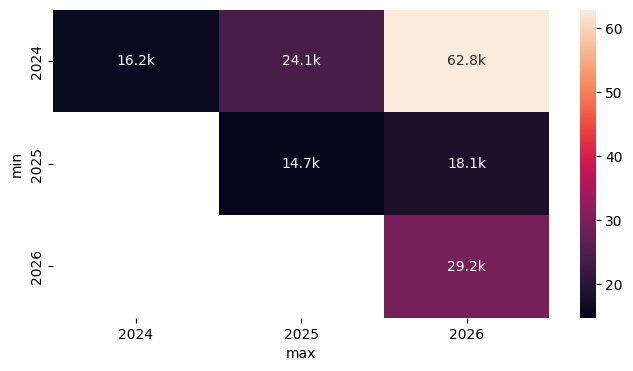

In [17]:
trans_matrix = test_periods.groupby(['min', 'max']).count().unstack()
trans_matrix.columns = trans_matrix.columns.droplevel()

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.heatmap(trans_matrix/1000,annot=True,fmt='.1f')
for t in ax.texts: t.set_text(t.get_text() + "k")
plt.show()


# train test distribution

In [18]:
real_activity_columns = ['atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out']

real_activity_volumn_columns = ['bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume']


def add_columns_for_distributions(data:pd.DataFrame) -> pd.DataFrame:
    data['prev_activity_in_days'] = data.groupby('customer_id')['date'].diff().dt.days
    data['first_activity'] = data.groupby('customer_id')['date'].transform('min')
    
    data['last_activity'] = data.groupby('customer_id')['date'].transform('max')
    data['days_between_first_and_last_activity'] = (data['last_activity']-
                                                        data['first_activity']).dt.days

    data['activities_count_today'] = data[real_activity_columns+
                                        real_activity_volumn_columns].gt(0).sum(axis=1)

    return data


In [19]:
df_train = add_columns_for_distributions(df_train)
df_test = add_columns_for_distributions(df_test)

In [20]:
train_stats = df_train.groupby('customer_id', as_index=False)\
           .agg(days_between_last_first=('days_between_first_and_last_activity','mean'),
                 prev_activity_in_days_mean=('prev_activity_in_days','mean'),
                real_activity_num_mean=('activities_count_today','count'),
                 num_activities = ('Id','count'))

test_stats = df_test.groupby('customer_id', as_index=False)\
           .agg(days_between_last_first=('days_between_first_and_last_activity','mean'),
                 prev_activity_in_days_mean=('prev_activity_in_days','mean'),
                real_activity_num_mean=('activities_count_today','count'),
                 num_activities = ('Id','count'))

train_stats = train_stats.agg(['count', 'mean', 'max']).T
test_stats = test_stats.agg(['count', 'mean', 'max']).T

train_stats.columns = [f"train_{col}" for col in train_stats.columns]
test_stats.columns = [f"test_{col}" for col in test_stats.columns]

sorted_columns = [col for pair in zip(train_stats.columns, test_stats.columns) for col in pair]
pd.concat([train_stats, test_stats], axis=1)[sorted_columns].T.round(2)

,customer_id,days_between_last_first,prev_activity_in_days_mean,real_activity_num_mean,num_activities
train_count,106179.00,106179.00,103765.00,106179.00,106179.00
test_count,165155.00,165155.00,128886.00,165155.00,165155.00
train_mean,53091.54,1233.46,45.06,36.98,36.98
test_mean,82595.25,376.51,75.14,8.24,8.24
train_max,106186.00,5821.00,449.00,362.00,362.00
test_max,165324.00,1043.00,971.00,84.00,84.00


# split periods

In [21]:
bins = [2008, 2011, 2014, 2017, 2020, 2023]
# we will drop 2008 data

labels = [f'{bins[i]+1}-{bins[i+1] }' for i in range(len(bins) -1)]
df_train['year_bin'] = pd.cut(df_train['year'], bins=bins, right=True,
                              labels=labels, include_lowest=False,)

In [22]:
df_train.groupby('year_bin',observed=False)['year'].agg(['min','max'])

,min,max
year_bin,,
2009-2011,2009,2011
2012-2014,2012,2014
2015-2017,2015,2017
2018-2020,2018,2020
2021-2023,2021,2023


# create target variable

In [23]:
print(df_train.shape)
print(df_test.shape)

(3926058, 34)
(1360472, 34)


In [24]:
df_train.groupby('customer_id')['prev_activity_in_days'].max().value_counts().head()

prev_activity_in_days
1.0      8633
2.0      5037
376.0    3458
378.0    3339
375.0    3333
Name: count, dtype: int64

<Axes: >

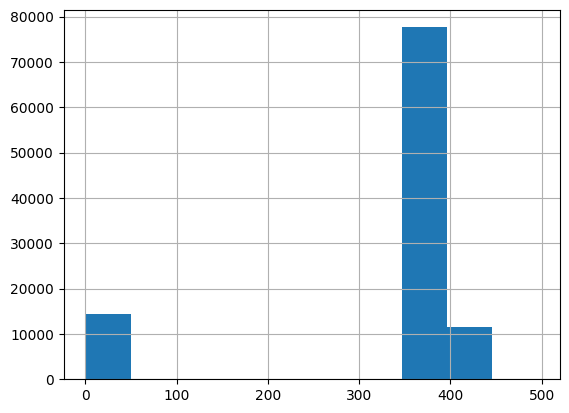

In [25]:
df_train.groupby('customer_id')['prev_activity_in_days'].max().hist()

In [26]:
DAYS_BEFORE_LAST_ACTIVITY = 400

CONTEXT_WINDOW = 365

## target
## TODO define the target better
##churn 1 

df_train[f'within_{DAYS_BEFORE_LAST_ACTIVITY}_days_of_last_activity'] =\
                df_train['date'] >=(df_train['last_activity'] - timedelta(days=DAYS_BEFORE_LAST_ACTIVITY))

df_train['churn_1'] = df_train[f'within_{DAYS_BEFORE_LAST_ACTIVITY}_days_of_last_activity']

# churn 2
df_train['prev_activity_more_than_year'] = df_train.prev_activity_in_days>DAYS_BEFORE_LAST_ACTIVITY

df_train['churn_2'] = df_train.groupby("customer_id")['prev_activity_more_than_year'].cumsum()


In [27]:

# prev activity features
df_train['expanding_mean_prev_activity'] = df_train.groupby('customer_id')['prev_activity_in_days'].expanding()\
                            .mean().reset_index(level=0)['prev_activity_in_days']


df_train[f'rolling_mean_prev_activity_{CONTEXT_WINDOW}D'] = df_train.groupby('customer_id').rolling(f'{CONTEXT_WINDOW}D',on='date')\
    .mean('prev_activity_in_days').reset_index(level=0)['prev_activity_in_days']

df_train['prev_activity_larger_than_men'] = (df_train['prev_activity_in_days']>
                                             df_train['expanding_mean_prev_activity'])


df_train['churn_3'] = df_train.groupby("customer_id")['prev_activity_larger_than_men'].cumsum()

## activity volume



In [28]:
df_train[['date','prev_activity_in_days','expanding_mean_prev_activity']].sample(6)

,date,prev_activity_in_days,expanding_mean_prev_activity
205623,2016-04-05,2.0,1.062500
328365,2022-05-16,1.0,1.200000
86255,2019-11-10,1.0,37.357143
101244,2021-07-23,1.0,107.285714
71672,2019-03-04,372.0,24.437500
1671,2021-12-24,1.0,28.802469


# feature engineering

## extract csas and touchpoints

In [29]:
def extract_csat_scores(data:pd.DataFrame) -> pd.DataFrame:
    csat_scores_explode = pd.json_normalize(data['csat_scores'])
    csat_scores_explode.index = csat_scores_explode.index.values
    csat_scores_explode.columns = ['csat_appointment', 'csat_email', 'csat_phone', 'csat_whatsapp']

    return csat_scores_explode


def extract_touchpoints(data:pd.DataFrame) -> pd.DataFrame:
    data['touchpoints_count'] = data['touchpoints'].apply(Counter)
    touchpoints_explode = pd.json_normalize(data['touchpoints_count'])
    data.drop('touchpoints_count',axis=1,inplace=True)
    touchpoints_explode.columns = ['touchpoint_whatsapp', 'touchpoint_email', 'touchpoint_appointment', 'touchpoint_phone']
    return touchpoints_explode
    

def add_csat_and_touchpoints(data:pd.DataFrame) -> pd.DataFrame:
    
    data.reset_index(drop=True,inplace=True)
    csat_scores = extract_csat_scores(data)
    data = pd.concat([data,csat_scores],axis=1)
    #data.drop('csat_scores',axis=1,inplace=True)
    
    touchpoints_explode = extract_touchpoints(data)
    data = pd.concat([data,touchpoints_explode],axis=1)
    #data.drop('touchpoints',axis=1,inplace=True)
    return data

In [30]:
df_train = add_csat_and_touchpoints(df_train)
df_test = add_csat_and_touchpoints(df_test)

## basic features

In [31]:
real_activity_columns = ['atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out']

real_activity_volumn_columns = ['bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume']



csat_columns = ['csat_whatsapp','csat_phone','csat_email','csat_appointment']

def add_basic_features(data:pd.DataFrame) -> pd.DataFrame:
    
    data['activities_count_today'] = data[real_activity_columns+
                                            real_activity_volumn_columns].gt(0).sum(axis=1)
    
    data['total_volume_in'] = data[[c for c in real_activity_volumn_columns if 'in_volume' in c]].sum(axis=1)
    data['total_volume_out'] = data[[c for c in real_activity_volumn_columns if 'out_volume' in c]].sum(axis=1)
    
    data['csat_answeres'] = data[csat_columns].count(axis=1)
    
    return data

In [32]:
%%time

df_train = add_basic_features(df_train)
df_test = add_basic_features(df_test)


CPU times: user 2.27 s, sys: 85.5 ms, total: 2.35 s
Wall time: 2.26 s


## agg features

In [33]:
rolling_mean_columns = ['atm_transfer_in', 'atm_transfer_out', 
                     'bank_transfer_in','bank_transfer_out',
                     'crypto_in','crypto_out',
                        'bank_transfer_in_volume','bank_transfer_out_volume',
                        'crypto_in_volume', 'crypto_out_volume',
                        
                       'interest_rate',
                        'activities_count_today',
                        'csat_answeres',
                        'csat_whatsapp','csat_phone','csat_email','csat_appointment'
        
                       ]

rolling_sum_columns = ['touchpoint_whatsapp', 'touchpoint_email', 'touchpoint_appointment',
       'touchpoint_phone','csat_answeres',]

rolling_count_columns = ['Id']
 
cumsum_columns = [ 'bank_transfer_in',
                     'bank_transfer_out']

new_rolling_mean_columns = [col+f'_roll_mean_{CONTEXT_WINDOW}' for col in rolling_mean_columns]
new_rolling_sum_columns = [col+f'_roll_sum_{CONTEXT_WINDOW}' for col in rolling_sum_columns]
new_rolling_count_columns = [col+f'_roll_count_{CONTEXT_WINDOW}' for col in rolling_count_columns]
new_cumsum_columns = [col+'_cumsum' for col in cumsum_columns]



In [34]:
def create_rolling_features(data:pd.DataFrame,
                            context_window:int = CONTEXT_WINDOW,
                            group_column:list[str] = ['customer_id']) -> pd.DataFrame:

    if len(group_column) == 1:
        level = 0
    else:
        level=None

    #data = data.reset_index(drop=True)
    

    data[new_rolling_mean_columns] = data.groupby(group_column).\
    rolling(f'{context_window}D',on='date')\
    .mean(rolling_mean_columns).reset_index(level=level)[rolling_mean_columns]
    
    
    data[new_rolling_sum_columns] = data.groupby(group_column).\
    rolling(f'{context_window}D',on='date')\
    .sum(rolling_sum_columns).reset_index(level=level)[rolling_sum_columns]
    
    
    data[new_rolling_count_columns] = data.groupby(group_column).\
    rolling(f'{context_window}D',on='date')\
    .count(rolling_count_columns).reset_index(level=level)[rolling_count_columns]
    

    return data

In [35]:
def create_expanding_features(data:pd.DataFrame,group_column:list[str] = ['customer_id']) -> pd.DataFrame:
    
    data[new_cumsum_columns] = data.groupby(group_column)[cumsum_columns].cumsum()
    
    data['avg_interest_rate'] = data.groupby(group_column)['interest_rate'].\
                                expanding().mean().reset_index()['interest_rate']
    
    data['min_interest_rate'] = data.groupby(group_column)['interest_rate'].\
                                expanding().min().reset_index()['interest_rate']
    
    data['max_interest_rate'] = data.groupby(group_column)['interest_rate'].\
                                expanding().max().reset_index()['interest_rate']

    return data

In [36]:
%%time 

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    

    df_train = create_rolling_features(df_train,CONTEXT_WINDOW,['customer_id','year_bin'])
    df_test = create_rolling_features(df_test)

    df_train = create_expanding_features(df_train,['customer_id','year_bin'])
    df_test = create_expanding_features(df_test)

CPU times: user 12min 35s, sys: 21.5 s, total: 12min 56s
Wall time: 12min 56s


In [37]:
CONTEXT_WINDOW = 60
new_rolling_mean_columns = [col+f'_roll_mean_{CONTEXT_WINDOW}' for col in rolling_mean_columns]
new_rolling_sum_columns = [col+f'_roll_sum_{CONTEXT_WINDOW}' for col in rolling_sum_columns]
new_rolling_count_columns = [col+f'_roll_count_{CONTEXT_WINDOW}' for col in rolling_count_columns]

In [38]:
%%time 

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    

    df_train = create_rolling_features(df_train,CONTEXT_WINDOW,['customer_id','year_bin'])
    df_test = create_rolling_features(df_test)

CPU times: user 19min 43s, sys: 30.5 s, total: 20min 14s
Wall time: 20min 14s


## more features

In [40]:

churn_columns = ['days_between_first_and_last_activity','year_bin','prev_activity_more_than_year',
   'churn_2','prev_activity_larger_than_men', 'expanding_mean_prev_activity',

                 'churn_1', 'churn_3','year','first_activity','last_activity']

drop_columns = ['Id', 'customer_id','date_of_birth','name','touchpoints',
                'rolling_mean_prev_activity_365D', 'prev_activity_larger_than_mean',

                
                'address', 'date','within_365_days_of_last_activity','touchpoints','csat_scores']

fraud_columns = ['churn_due_to_fraud','model_predicted_fraud',]


categorical_columns = ['country','job']

target = 'within_400_days_of_last_activity'

In [43]:
cols_for_model = [c for c in df_train.columns if c not in
                  drop_columns+churn_columns+fraud_columns+[target]]

# inspect 10 sample 

In [44]:
real_target = [74330,41422,98852,41620,84714,84703,84692,3367,	41857]
real_target_df = df_train[df_train['customer_id'].isin(real_target)].copy()
real_target_df['target'] = np.where(real_target_df['customer_id']==3367,1,0)

## pca

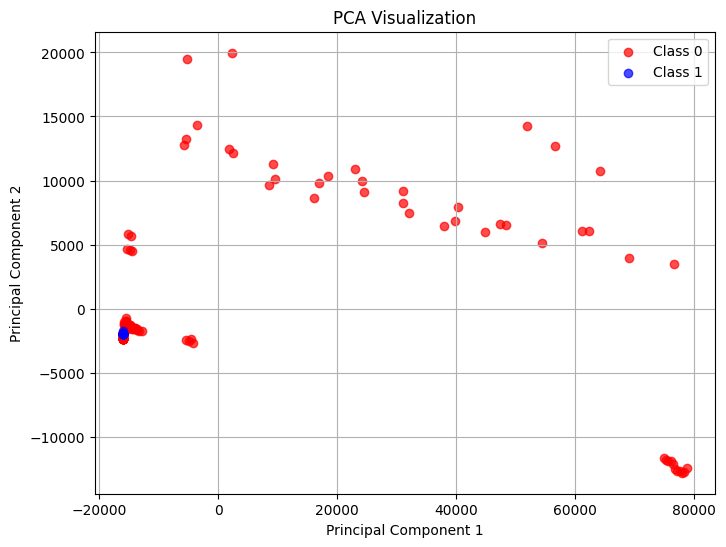

In [46]:
from sklearn.decomposition import PCA
X = real_target_df[list(set(cols_for_model) - set(categorical_columns))].fillna(0)
y = real_target_df['target']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', label='Class 0', alpha=0.7
)
plt.scatter(
    X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', label='Class 1', alpha=0.7
)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

## tsne

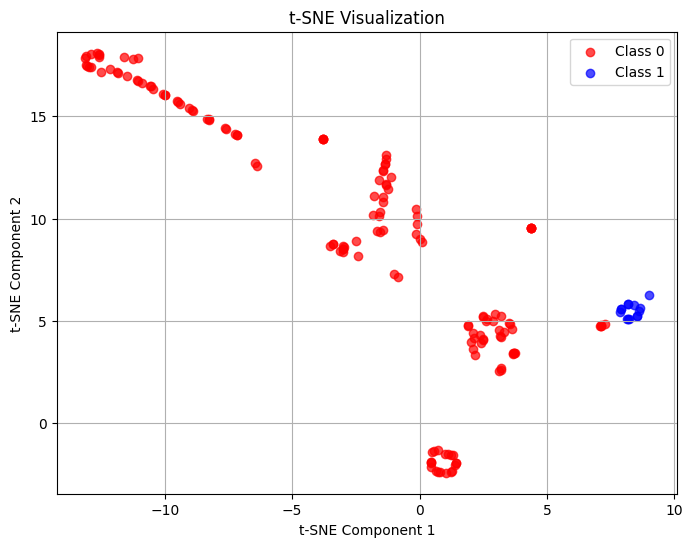

In [47]:
from sklearn.manifold import TSNE

X = real_target_df[list(set(cols_for_model) - set(categorical_columns))].fillna(0)
y = real_target_df['target']

tsne = TSNE(n_components=2, random_state=17, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[y == 0, 0], X_tsne[y == 0, 1], color='red', label='Class 0', alpha=0.7
)
plt.scatter(
    X_tsne[y == 1, 0], X_tsne[y == 1, 1], color='blue', label='Class 1', alpha=0.7
)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()

# train model

In [48]:
df_train[target].mean()

0.27805116480704056

In [49]:

X = df_train[cols_for_model]
y = df_train[target]

test_data_for_model = df_test[cols_for_model]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

In [50]:
%%time
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0,  
    class_weights=[1, int(1/df_train[target].mean())], 
    #task_type='GPU',
    loss_function="Logloss",
    cat_features = categorical_columns
)

model.fit(X_train, y_train)

CPU times: user 8min 28s, sys: 3.97 s, total: 8min 32s
Wall time: 2min 15s


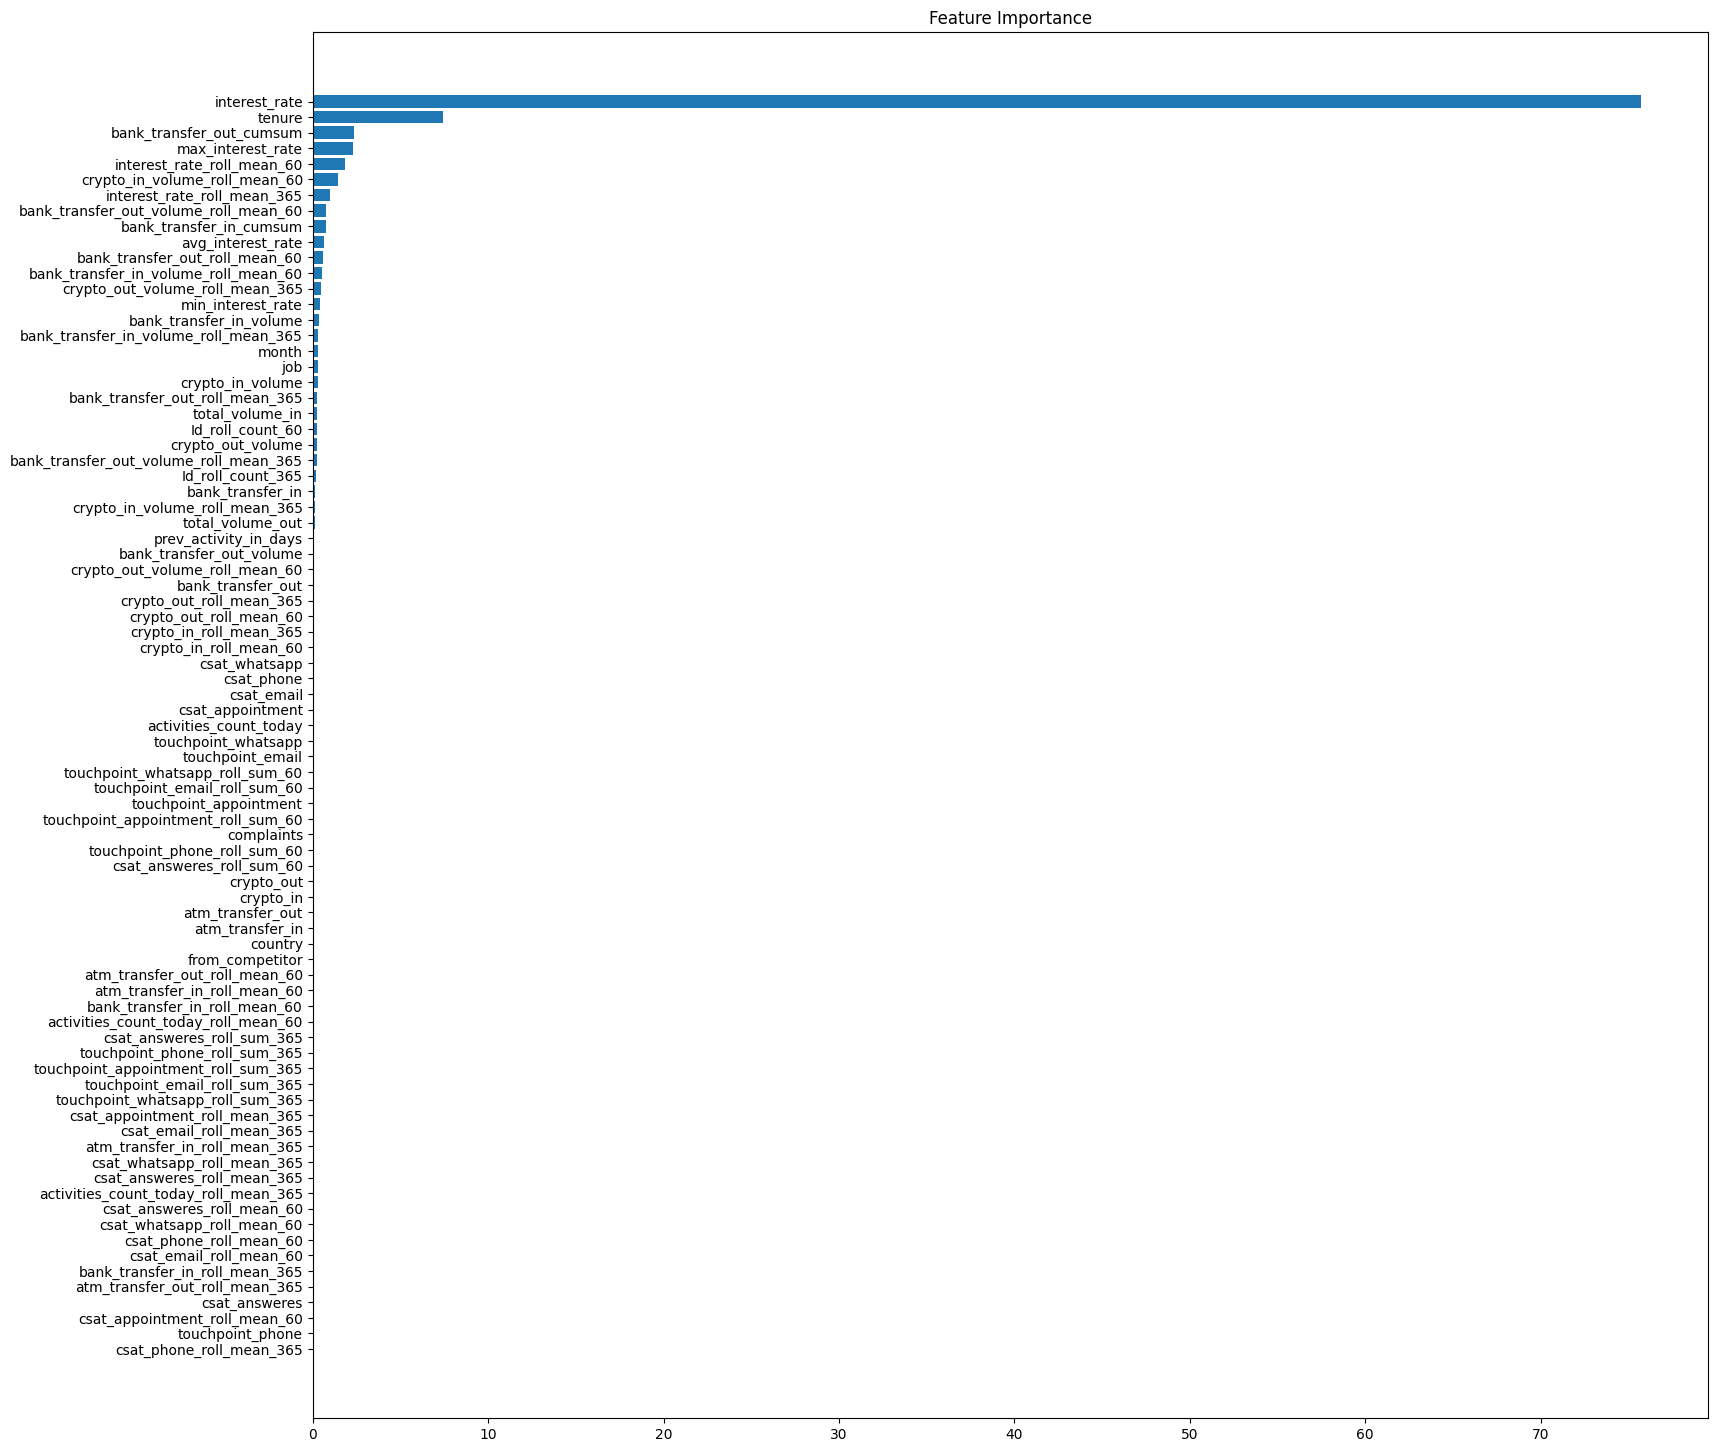

In [51]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(18, 18))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance');

In [52]:
y_pred = model.predict(X_val)

In [53]:
log_loss(y_val, y_pred)


6.721542872644629

In [54]:
print("log_loss:", log_loss(y_val, y_pred))
#print("recall_score:", recall_score(y_val, y_pred))
print("f1_score:", f1_score(y_val, y_pred))

print("\nClassification Report:\n", classification_report(y_val, y_pred))

log_loss: 6.721542872644629
f1_score: 0.6803146443222332

Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.85      0.87    566883
        True       0.65      0.71      0.68    218329

    accuracy                           0.81    785212
   macro avg       0.77      0.78      0.77    785212
weighted avg       0.82      0.81      0.82    785212



# predict on test

In [55]:
df_test.shape

(1360472, 96)

In [56]:
df_test['churn'] = model.predict_proba(test_data_for_model)[:, 1]

In [57]:
df_test['churn'].mean()

0.4066445635129223

# shap

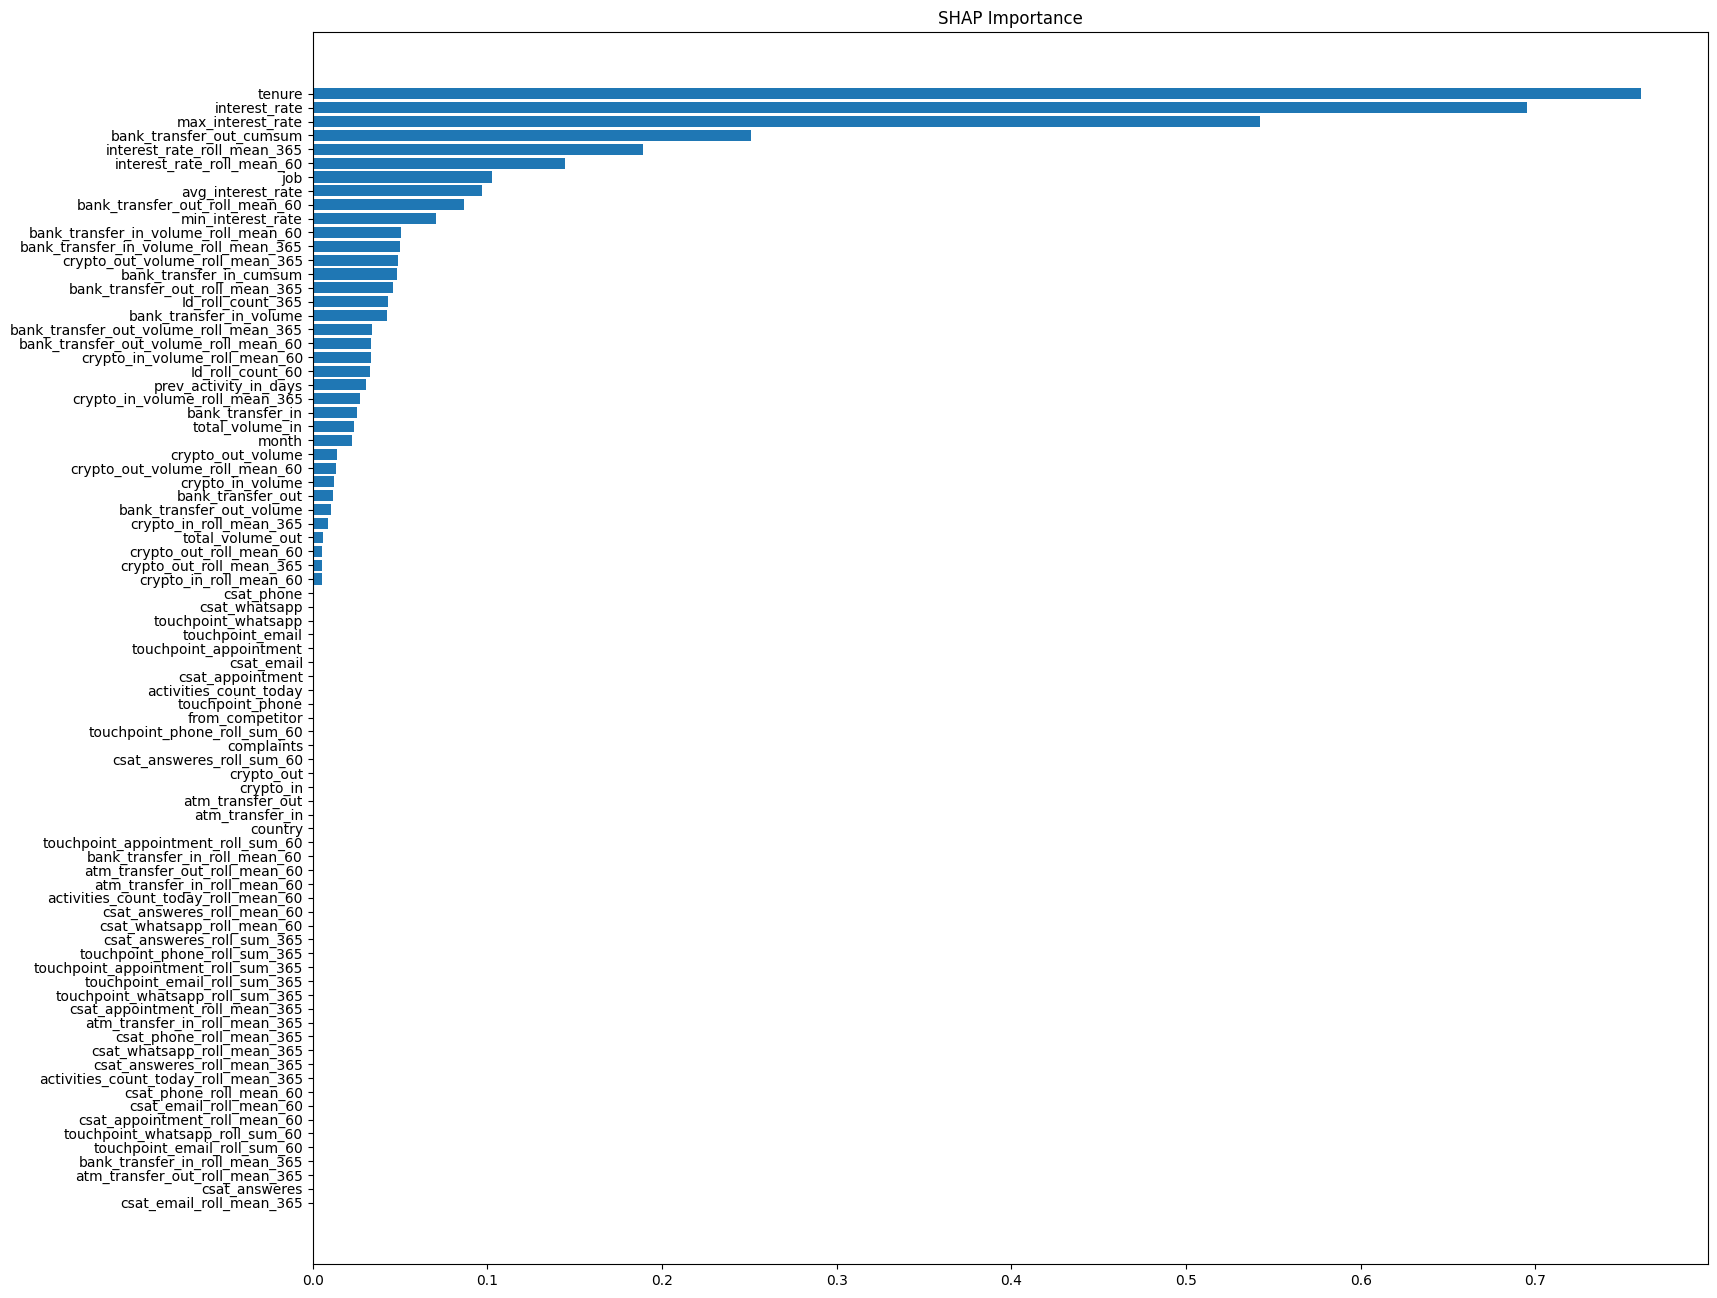

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(test_data_for_model)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test_data_for_model.columns)[sorted_idx])
plt.title('SHAP Importance');

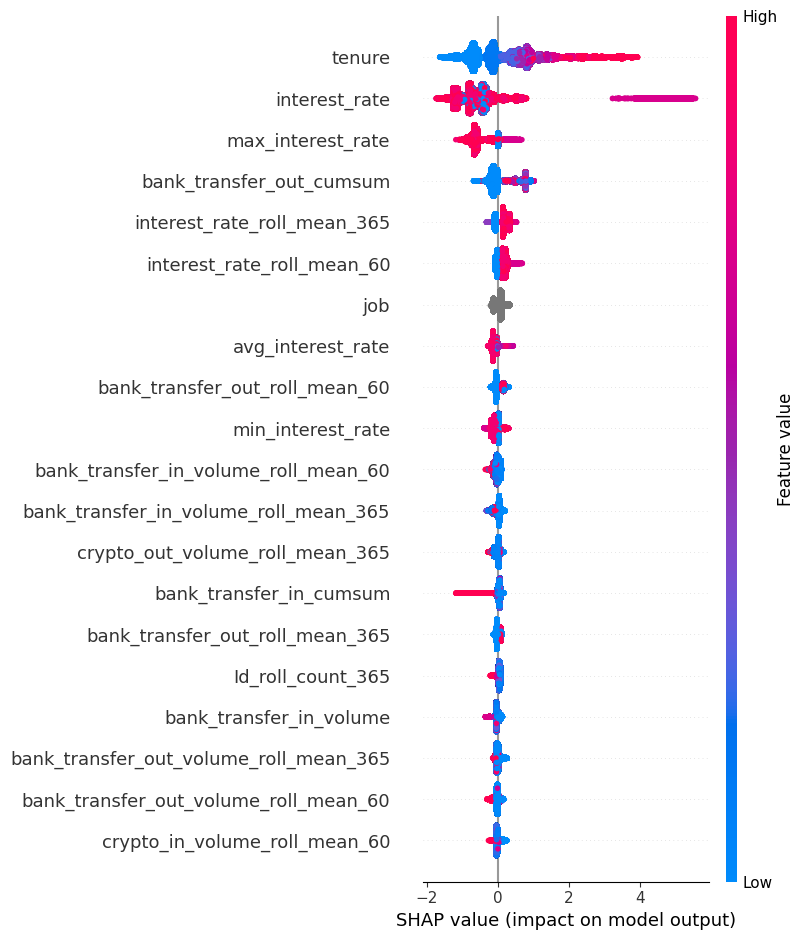

In [59]:
shap.summary_plot(shap_values)

In [61]:
df_test['churn'].nlargest(n= 5)

16691    0.999827
28122    0.999798
18258    0.999791
25889    0.999790
11747    0.999784
Name: churn, dtype: float64

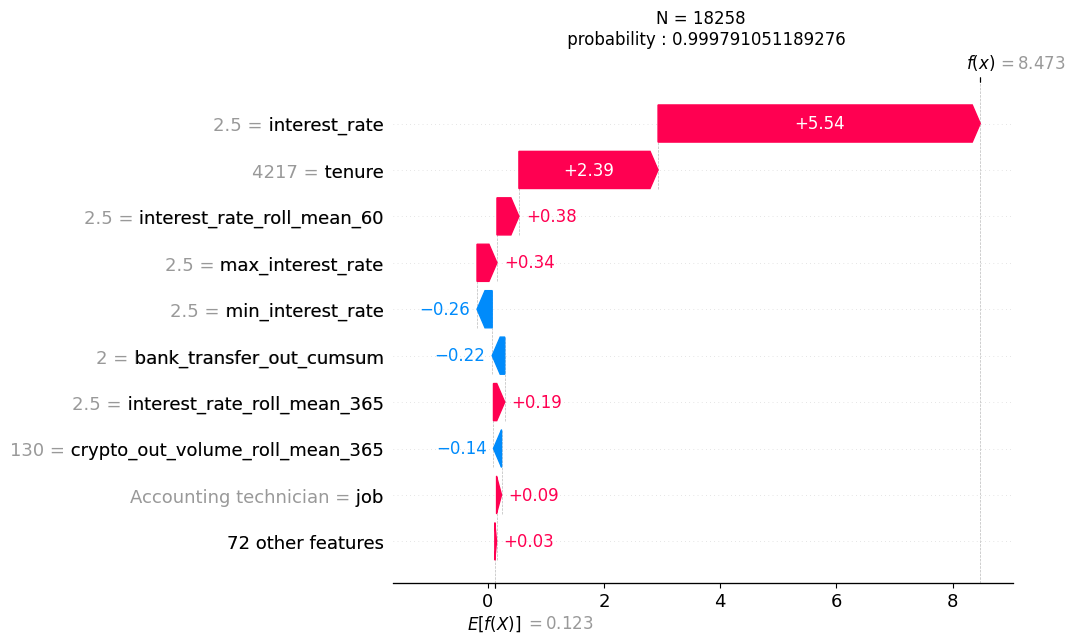

In [63]:
plot_shap_for_observation(18258,shap_values)

In [62]:
df_test['churn'].nsmallest(n= 5)

1174761    0.009124
944164     0.009340
826463     0.009680
826460     0.010126
1174755    0.010204
Name: churn, dtype: float64

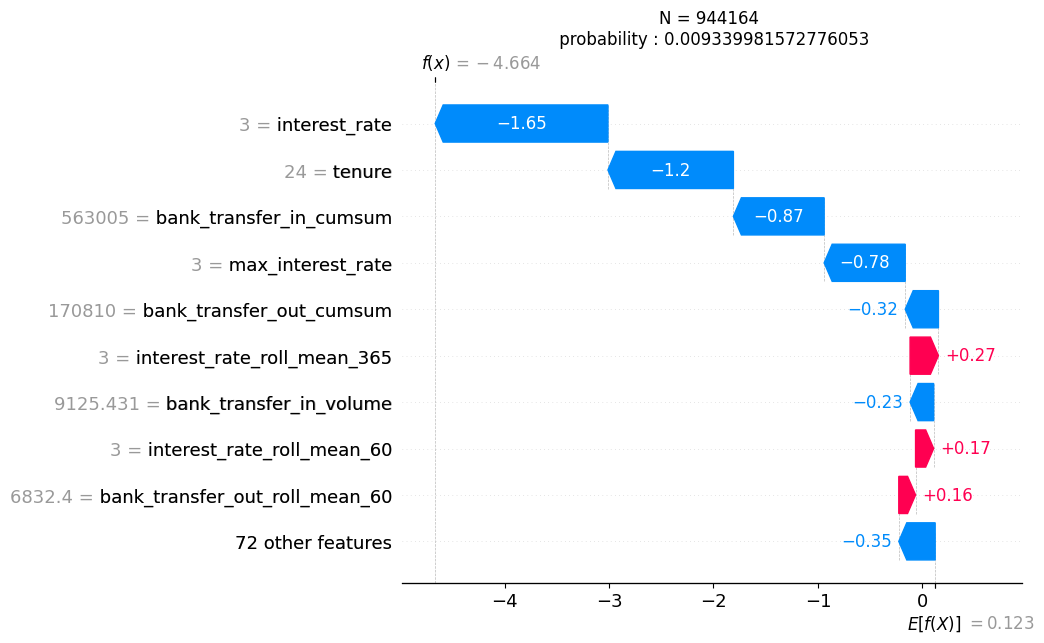

In [64]:
plot_shap_for_observation(944164,shap_values)

# create submission

In [65]:
df_test.churn.mean()

0.4066445635129223

In [66]:
df_test.churn = round(df_test.churn,5)

In [67]:
df_test.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,csat_phone_roll_mean_60,csat_email_roll_mean_60,csat_appointment_roll_mean_60,touchpoint_whatsapp_roll_sum_60,touchpoint_email_roll_sum_60,touchpoint_appointment_roll_sum_60,touchpoint_phone_roll_sum_60,csat_answeres_roll_sum_60,Id_roll_count_60,churn
0,7284407,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2026-02-27,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.75342
1,7227547,2,2.8,Bonnie Carr,Greece,1947-05-27,00867 Dominguez Camp Apt. 575\nPort Josephland...,2026-01-03,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.23464
2,6579775,3,0.0,Michael Mcknight,Romania,2002-11-09,"36495 Travis Ranch Apt. 055\nJustinmouth, CO 7...",2024-10-27,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.85769
3,6742757,4,3.2,Sharon Howard,Switzerland,1973-09-16,"4660 Wilson Streets Apt. 764\nSouth Amyside, P...",2025-02-22,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.26827
4,6225730,5,3.0,Emily Solis,Netherlands,2006-06-30,"664 Brown Rapid\nBrianburgh, MN 10337 Netherlands",2024-02-01,0,0,...,8.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,0.95452


In [68]:
df_test[['Id','churn']].set_index('Id').to_csv('submission.csv')